In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import os
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [2]:
data = pd.read_csv('genre_filtered_movie.csv')
data

,Unnamed: 0,Unnamed: 0.1,movie_id,cast,summary_wiki,movie_name,info_json,Animation,Family,Fantasy,...,War,Western,Adventure,Horror,Drama,Romance,Action,Crime,Comedy,History
0,0,0,Birds of Prey: And the Fantabulous Emancipatio...,"[{'nm8698119': [' Paloma Rabinov']}, {'nm43992...",Harley Quinn narrates the events of her life l...,Birds of Prey: And the Fantabulous Emancipatio...,{'Title': 'Birds of Prey: And the Fantabulous ...,0,0,0,...,0,0,1,0,0,0,1,1,0,0
1,1,1,Sonic the Hedgehog,"[{'nm9961714': [' Melody Nosipho Niemann']}, {...",Sonic is an extraterrestrial blue hedgehog who...,Sonic the Hedgehog,"{'Title': 'Sonic the Hedgehog', 'Year': '2020'...",0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,2,2,Vikings,"[{'nm1573253': [' Alexander Ludwig']}, {'nm540...",The series is inspired by the tales of the Nor...,Vikings,"{'Title': 'Vikings', 'Year': '2013–', 'Rated':...",0,0,0,...,1,0,1,0,1,1,1,0,0,1
3,3,3,Star Trek: Picard,"[{'nm0403335': [' Michelle Hurd']}, {'nm108505...",Many years have passed since Data's demise. Fo...,Star Trek: Picard,"{'Title': 'Star Trek: Picard', 'Year': '2020–'...",0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,4,4,Fantasy Island,"[{'nm0740264': [' Michael Rooker']}, {'nm10666...",This article's plot summary may be too long or...,Fantasy Island,"{'Title': 'Fantasy Island', 'Year': '2020', 'R...",0,0,0,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1575,1663,1838,High Society,"[{'nm0526184': [' John Lund']}, {'nm0000038': ...",Successful jazz musician C.K. Dexter Haven (wi...,High Society,"{'Title': 'High Society', 'Year': '1956', 'Rat...",0,0,0,...,0,0,0,0,0,1,0,0,1,0
1576,1664,1839,Chi-Raq,"[{'nm1869008': [' Anya Engel-Adams']}, {'nm000...","In Chicago's Southside, as the events are narr...",Chi-Raq,"{'Title': 'Chi-Raq', 'Year': '2015', 'Rated': ...",0,0,0,...,0,0,0,0,1,0,0,1,1,0
1577,1665,1840,Om Shanti Om,"[{'nm0082848': [' Bindu']}, {'nm2061852': [' A...","In 1977 , Om Prakash Makhija, a junior artist ...",Om Shanti Om,"{'Title': 'Om Shanti Om', 'Year': '2007', 'Rat...",0,0,0,...,0,0,0,0,1,1,1,0,1,0
1578,1667,1842,Teletubbies,"[{'nm0799619': [' John Simmit']}, {'nm0266623'...","The programme takes place in a grassy, floral ...",Teletubbies,"{'Title': 'Teletubbies', 'Year': '1997–2001', ...",0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# removing nan items
nan_items = []
for i,d in data.iterrows():
    if type(d['summary_wiki'])!= str:
        nan_items.append(i)
data = data.drop(nan_items)

In [4]:
# Removing names
nlp = spacy.load('en_core_web_sm')
stop_words = stopwords.words("english")

#filter out names through nerc
def remove_names(text):
    document = nlp(text)
    ents = [e.text for e in document.ents if e.label_ != 'PERSON']
    return " ".join([item.text for item in document if item.text not in ents])

data['summary_no_names'] = data['summary_wiki'].apply(lambda x: remove_names(x))
data['cast']= [eval(c) for c in data['cast']]

In [5]:
# sampling
genres = ['Animation', 'Family', 'Fantasy', 'Mystery',
       'Sci-Fi', 'Thriller', 'Biography', 'Musical', 'War', 'Western',
       'Adventure', 'Horror', 'Drama', 'Romance', 'Action', 'Crime', 'Comedy',
       'History']

sample_movie_indexes = []
for g in genres:
    for i,m in data[data[g]==1].sample(2).iterrows():
        sample_movie_indexes.append(i)

train_index = [x for x in range(len(data)) if x not in sample_movie_indexes]

test_df = data.iloc[sample_movie_indexes, :]
data = data.iloc[train_index,:]

In [6]:
# tokenizer
def tokenize(content):
    letters_only = re.sub("[^a-zA-Z]"," ", content)
    lower_case = letters_only.lower()
    tokens = word_tokenize(lower_case)
    words = [w for w in tokens if not w in stop_words]
    stems = [stemmer.lemmatize(word) for word in words]
    return(stems)

In [7]:
#create dictionary and incorporating 1 to n-gram  -> change to tf-idf
stemmer = WordNetLemmatizer()
vectorizer = CountVectorizer(ngram_range = (1,2),
                             lowercase = True,
                             tokenizer=tokenize,
                             preprocessor = None,
                             max_features=5000)

tfidf_vect = TfidfVectorizer(analyzer = 'word',tokenizer = tokenize, lowercase = True)#, #ngram_range=(1, 2),
#                                    lowercase=True, tokenizer=tokenize,
#                                    preprocessor=None, max_features=10000)


#bag of words
bow = vectorizer.fit_transform(data['summary_no_names'])

# vectorizer.vocabulary_
tfidf = tfidf_vect.fit_transform(data['summary_no_names'])

In [8]:
nb_topics = 10
lda = LatentDirichletAllocation(n_components=nb_topics, max_iter=20,
                                learning_method='batch')
document_topics = lda.fit_transform(bow)
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vectorizer.get_feature_names())

def print_topics(topics, feature_names, sorting, topics_per_chunk=6, n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        these_topics = topics[i: i + topics_per_chunk]
        len_this_chunk = len(these_topics)
        words = []
        for i in range(n_words):
            try:
                words.append(feature_names[sorting[these_topics, i]])
            except:
                pass

    #setting up word dictionary for comparison
    word_dict = {}
    for i in topics:
        word_dict.update({i : [word[i] for word in words]})
    
    return word_dict

lda_topics = print_topics(topics=range(nb_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=nb_topics, n_words=15)

for i in range(nb_topics):
    print(i,': ' ,lda_topics[i], '\n')

0 :  ['war', 'soldier', 'army', 'force', 'order', 'officer', 'attack', 'george', 'men', 'battle', 'mission', 'killed', 'camp', 'general', 'take'] 

1 :  ['king', 'harry', 'father', 'love', 'find', 'return', 'take', 'woman', 'tom', 'tell', 'mother', 'friend', 'rachel', 'later', 'back'] 

2 :  ['mr', 'family', 'child', 'max', 'chris', 'home', 'elizabeth', 'father', 'charlie', 'mother', 'return', 'lady', 'go', 'new', 'take'] 

3 :  ['tell', 'home', 'school', 'go', 'frank', 'friend', 'new', 'take', 'father', 'day', 'house', 'family', 'jack', 'return', 'get'] 

4 :  ['john', 'ship', 'kill', 'escape', 'alien', 'team', 'crew', 'attempt', 'group', 'human', 'return', 'attack', 'dr', 'mike', 'find'] 

5 :  ['sarah', 'escape', 'help', 'world', 'power', 'kill', 'find', 'human', 'group', 'city', 'new', 'take', 'agent', 'return', 'reveals'] 

6 :  ['town', 'kill', 'gang', 'men', 'shoot', 'brother', 'money', 'take', 'back', 'gun', 'horse', 'family', 'killed', 'find', 'tell'] 

7 :  ['find', 'house', 

In [22]:
def topic_report(file, df, topics, feature_names, sorting):
    
    file.write('TOPICS REPORT \n')
    lda_topics = print_topics(topics=range(topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=topics)

    for i in range(topics):
        file.write('---------------- \n')
        file.write('TOPIC : '+str(i)+ '\n')
        file.write('MOST IMPORTANT WORDS: '+str(lda_topics[i])+'\n')
        file.write('MOVIES OF THIS TOPIC: \n')
        for i,m in df[df['clusters'] == i].iterrows():
            file.write(m['movie_id']+"\n")
    

In [10]:
lda.components_[0].sum()

36431.15899392211

In [11]:
data['clusters'] = np.argmax(document_topics, axis=1)

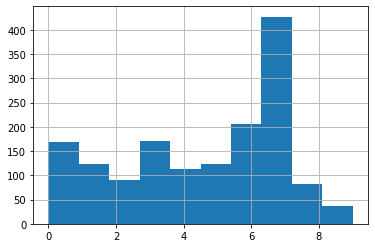

In [12]:
data['clusters'].hist()

In [13]:
def topic_word_cloud(lda_model,feature_names, topic):
    
    word_matrix = lda_model.components_[topic]
    word_dict = dict(zip(feature_names, word_matrix))
    wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(word_dict)
    #plt.figure(figsize=(10, 10))
    #plt.imshow(wc, interpolation='bilinear')
    #plt.axis('off')
    #plt.show()
    return wc

In [14]:
def get_list_of_actors_clustering(lda_model, document_topics, word_vectorizer, text):
    feature_vector = word_vectorizer.transform([text])
    topic_distribution = lda_model.transform(feature_vector)
    topic = topic_distribution[0].argmax()
    related_documents = []
    clusters = np.argmax(document_topics, axis = 1)
    for i, e in enumerate(clusters):
        if e == topic:
            related_documents.append(i)
    return (topic, related_documents)
    

In [15]:
def euclidean_distance(a,b):
    
    return np.sqrt(np.power(a-b,2).sum())

In [16]:
def baseline(document_topics, word_vectorizer, text, k = 10):
    feature_vector = word_vectorizer.transform([text]).toarray()[0]
    distances = []
    for document in document_topics.toarray():
        distances.append(euclidean(feature_vector, document))
    
    return np.argsort(np.array(distances))[0:k]

In [17]:
def get_list_of_k_nearest_documents(lda_model, document_topics, word_vectorizer, text, k = 10):
    feature_vector = word_vectorizer.transform([text])
    topic_distribution = lda_model.transform(feature_vector)[0]
    distances = []
    for document in document_topics:
        distances.append(euclidean(topic_distribution, document))
    
    return np.argsort(np.array(distances))[0:k]

In [18]:
cast = list(data['cast'])
def retrieve_cast(cast, document_indexes):
    actors = dict()
    
    for index in document_indexes:
        for d in cast[index]:
            for v in d.values():
                actor = v[0][1:]
                if actor not in actors:
                    actors[actor] = 1
                else:
                    actors[actor]+=1
    return sorted(actors.items(), key = lambda x:x[1], reverse = True)

In [19]:
def log_actors(actors):
    return [actor[0]+' : '+ str(actor[1])+'\n' for actor in actors][0:10]

baseline ./results/tfidf/baseline.txt
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training
word cloud
experimenting
baseline ./results/bow/baseline.txt
lda training
word cloud
experimenting
lda training
word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting
lda training


C:\Users\FCH\.conda\envs\tm\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


word cloud
experimenting


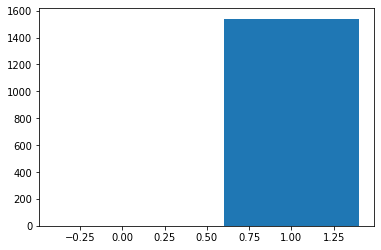

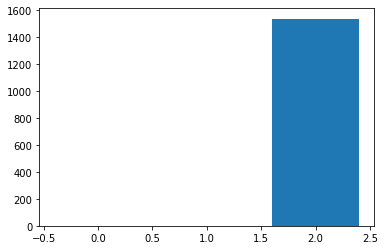

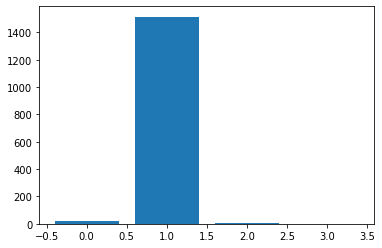

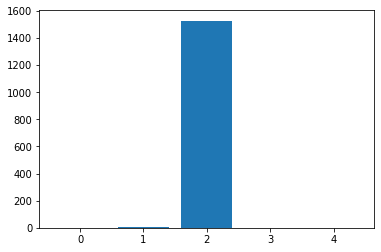

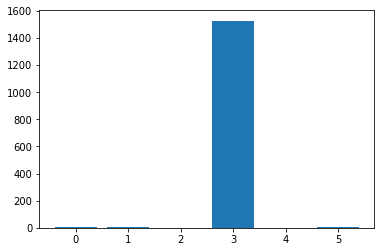

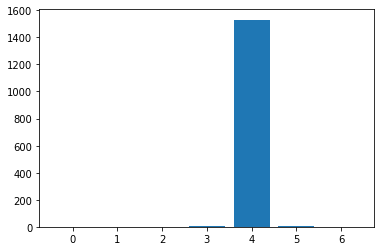

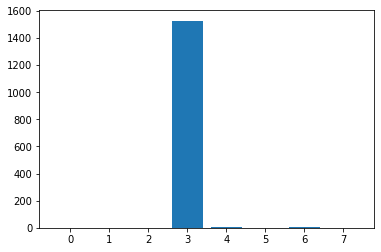

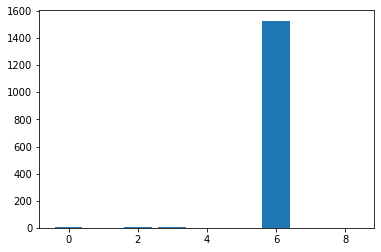

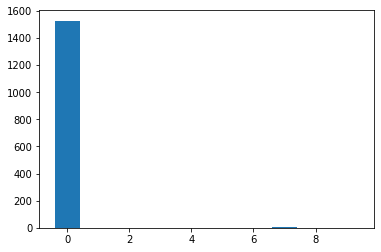

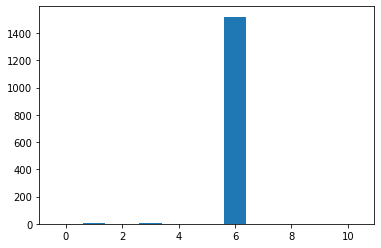

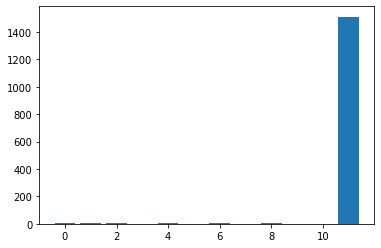

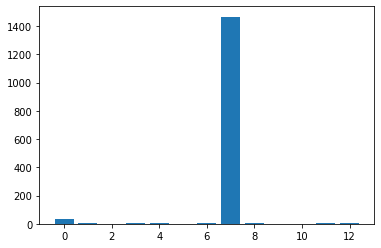

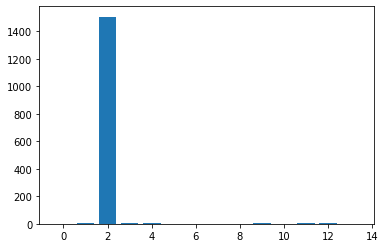

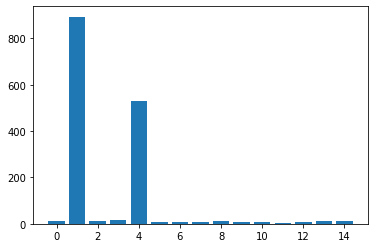

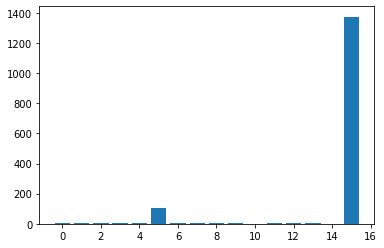

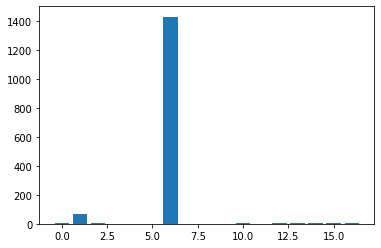

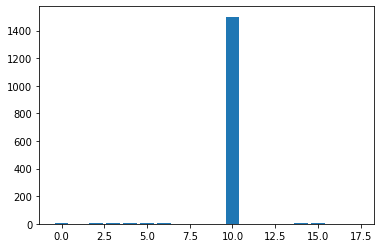

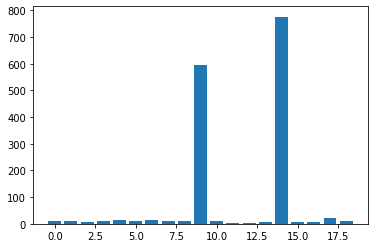

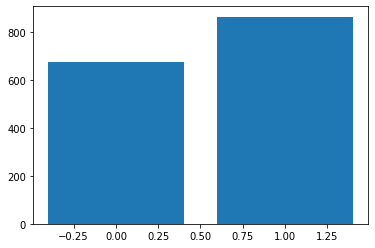

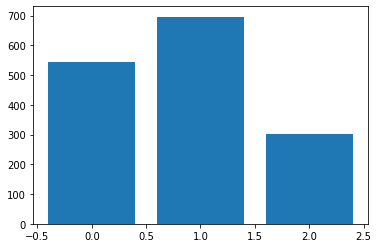

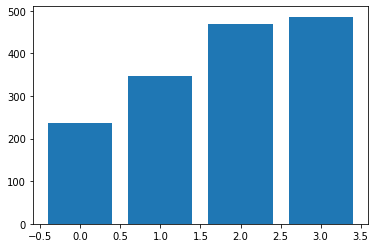

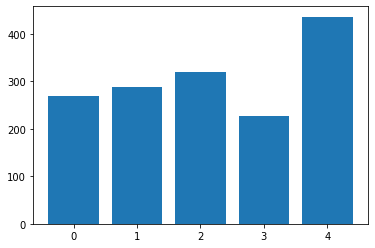

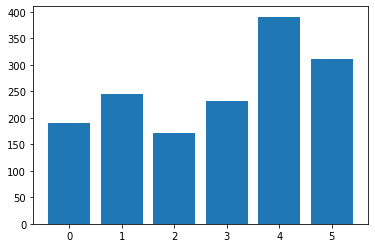

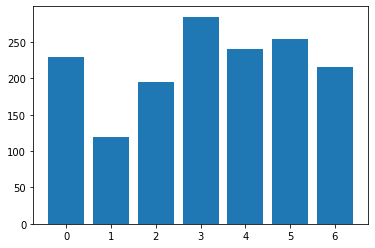

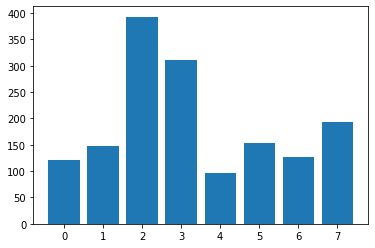

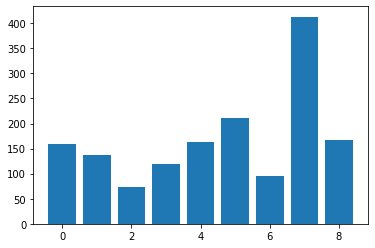

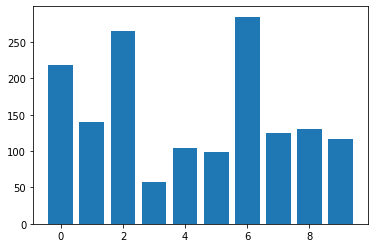

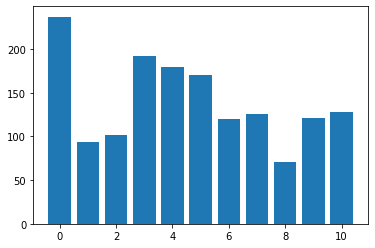

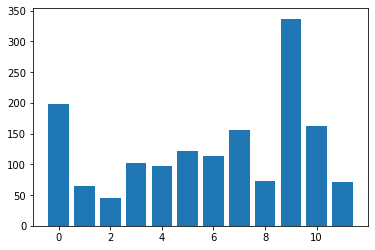

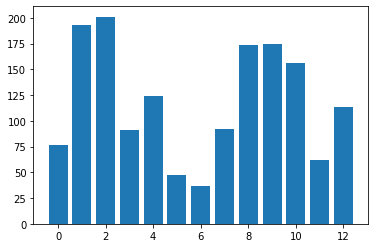

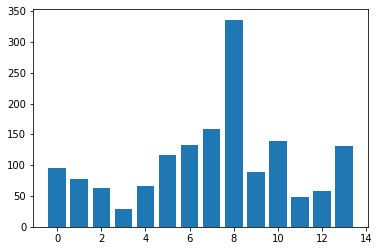

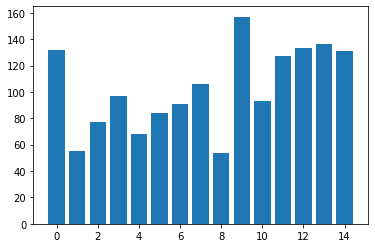

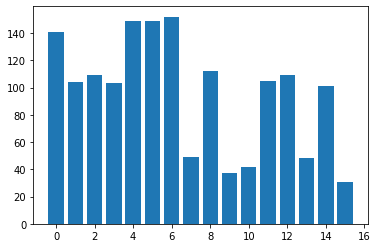

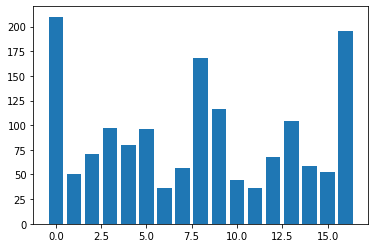

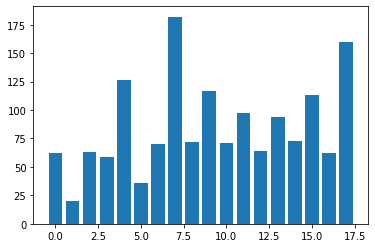

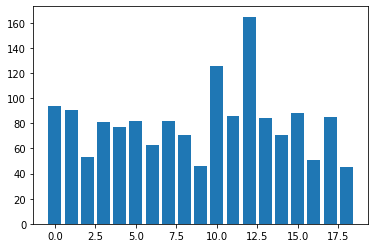

In [23]:
# Selecting the vectorizer
bow = CountVectorizer(lowercase = True,tokenizer=tokenize)
tfidf = TfidfVectorizer(analyzer = 'word',tokenizer = tokenize, lowercase = True)

vectorizers = [tfidf, bow]
                
# Selecting number of topics
number_of_topics = list(range(2,20))
                        
# Selecting the k nearest
k_nearest = [3,5,10]


for v in vectorizers:
    path_string ='./results/'
    #print()
    if type(v)==TfidfVectorizer:
        path_string+='tfidf/'
    else:
        path_string+='bow/'
        
    feature_matrix = v.fit_transform(data['summary_no_names'])
    # baseline
    baseline_path = path_string+'baseline.txt'
    print('baseline',baseline_path )
    baseline_file = open(baseline_path, 'w+', encoding = 'utf-8')
    baseline_file.write('BASELINE FILE \n')
    for i,movie in test_df.iterrows():
        baseline_file.write('***************\n')
        baseline_file.write('MOVIE :'+movie['movie_id']+'\n')
        b = log_actors(retrieve_cast(cast,baseline(feature_matrix, v, movie['summary_wiki'])))
        baseline_file.writelines(b)
    baseline_file.close()
    
    for t in number_of_topics:
        experiment_path=path_string+"topic"+str(t)+"/"
        if not os.path.exists(experiment_path):
            os.mkdir(experiment_path)
            
        lda = LatentDirichletAllocation(n_components = t)
        print('lda training')
        document_topics = lda.fit_transform(feature_matrix)
        feature_names = np.array(v.get_feature_names())
        
        clusters =  np.argmax(document_topics, axis=1)
        data['clusters'] = clusters
        cluster_counts = [0 for _ in range(t)]
        for c in clusters:
            cluster_counts[c]+=1
        
        plt.figure()
        plt.bar(range(t), cluster_counts)
        plt.savefig(experiment_path+'cluster_distribution.png')
        
        t_report_file = open(experiment_path+'topic_report.txt','w+', encoding = 'utf-8')
        topic_report(t_report_file, data, t, np.array(v.get_feature_names()), np.argsort(lda.components_, axis=1)[:, ::-1])
        t_report_file.close()
        
        word_cloud_path = experiment_path+'wordclouds/'
        print('word cloud')
        if not os.path.exists(word_cloud_path):
            os.mkdir(word_cloud_path)
            
        for w in range(t):
            word_cloud = topic_word_cloud(lda, feature_names, w)
            word_cloud.to_file(word_cloud_path+str(w)+'.png')
        
        print('experimenting')
        for k in k_nearest:
            experiment_file_name =experiment_path+'k_'+str(k)+'.txt'
            experiment_file = open(experiment_file_name, 'w+', encoding = 'utf-8')
            experiment_file.write('Experiment \n')
            experiment_file.write("## METADATA ## \n")
            experiment_file.write("Vectorizer :"+ str(v)+'\n')
            experiment_file.write("N_topics :"+ str(t)+'\n')
            experiment_file.write("K_nearest :"+ str(k)+'\n')
            experiment_file.write("##############")
            
            for i,movie in test_df.iterrows():
                experiment_file.write('***********************\n')
                experiment_file.write('MOVIE :'+ movie['movie_id']+'\n')
                b = log_actors(retrieve_cast(cast,get_list_of_k_nearest_documents(lda,document_topics, v, movie['summary_wiki'], k = k)))
                experiment_file.writelines(b)
            
            experiment_file.close()
        
        experiment_file_name = experiment_path+'cluster.txt'
        experiment_file = open(experiment_file_name, 'w+', encoding = 'utf-8')
        experiment_file.write('Experiment cluster \n')
        
        for i,movie in test_df.iterrows():
            experiment_file.write('***********************\n')
            experiment_file.write('MOVIE :'+ movie['movie_id']+'\n')
            cl, doc_index = get_list_of_actors_clustering(lda, document_topics, v, movie['summary_wiki'])
            experiment_file.write('CLUSTER :' +str(cl)+'\n')
            b = log_actors(retrieve_cast(cast,doc_index))
            experiment_file.writelines(b)
        
        experiment_file.close()
            

In [ ]:
for v in vectorizers:
    print(type(v))

In [ ]:
type(vectorizers[1])==TfidfVectorizer